## Подготовительная работа

Импортируем модули, которые понадобятся в дальнейшем

In [1]:
%matplotlib inline

import os
from urllib import urlretrieve

import numpy as np

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image, display

import ee

from composite.composite import Aggregator

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Инициализируем EE:

In [2]:
ee.Initialize()

Функции, позволяющие отображать изображения (снимки) в блокнотах:

In [3]:
def get_path(image, geometry):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})

def download(image, geometry, path_out):
    path = get_path(image, geometry)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urlretrieve(path, path_out)

def show(path_out):
    plt.grid(False)
    plt.imshow(plt.imread(path_out))

## Пример работы

Создадим полигон, ограничивающий нашу область интересов.

In [4]:
aoi = ee.Geometry.Polygon(
        [[[131.66015625, 47.83774100755438],
          [133.9013671875, 48.569943077430054],
          [135.087890625, 48.36598134901881],
          [133.2421875, 45.08386374897908],
          [132.36328125, 43.447601069123124],
          [135.439453125, 43.765804051552465],
          [139.5263671875, 47.98501901992268],
          [139.8779296875, 50.200344653305514],
          [139.921875, 52.047985749215904],
          [138.2080078125, 52.34428838526162],
          [136.142578125, 51.72249069029722],
          [131.30859375, 49.605963198387286]]]);

## Композиты

Создадим 16-ти дневные композиты (аналоги которых использовались при отрисовке обучающего множества).

In [5]:
aggregator = Aggregator(['LANDSAT/LE07/C01/T1_RT_TOA', 'LANDSAT/LC08/C01/T1_RT_TOA'], function='median')
collection16 = aggregator.aggregate(aoi, 2016, 300, 365, 16)
collection17 = aggregator.aggregate(aoi, 2017, 0, 160, 16)

data = ee.ImageCollection(collection16.merge(collection17))

Добавим еще один канал - индекс NDSI:

In [6]:
def addNDSI(image):
    names = image.bandNames()
    names = names.insert(names.length(), 'ndsi')
    full_img = image.addBands(image.normalizedDifference(['blue', 'swir1']))
    return full_img.rename(names)

data = data.map(addNDSI)

Возьмем на вскидку третий из них:

In [7]:
image = data.toList(1, offset=2).get(0)
image = ee.Image(image)

Отобразим его:

In [8]:
vis = {'bands':['red', 'green', 'blue'], 'min': 0, 'max': 1}

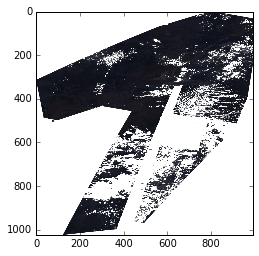

In [9]:
im = image.visualize(**vis)

path = 'aggr.png'
download(im, aoi, path)
show(path)

 Построим для гистограммы яркостей по каждому каналу:

In [10]:
scale = 600

# hist = image.reduceRegion(ee.Reducer.histogram(150), aoi, scale).getInfo()
values = image.reduceRegion(ee.Reducer.toList(), aoi, scale).getInfo()

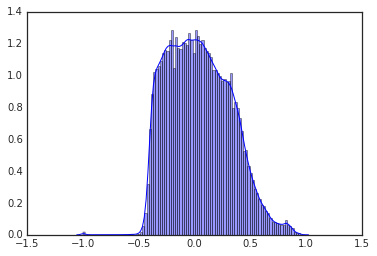

In [11]:
sns.set_style('white')
f = plt.figure()
plt.plot()
sns.distplot(values['ndsi'], bins=100)

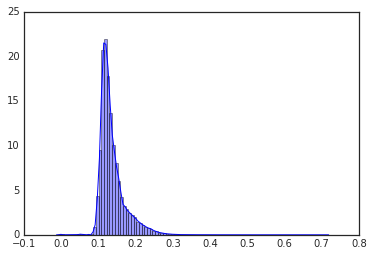

In [12]:
sns.set_style('white')
f = plt.figure()
plt.plot()
sns.distplot(values['blue'], bins=100)

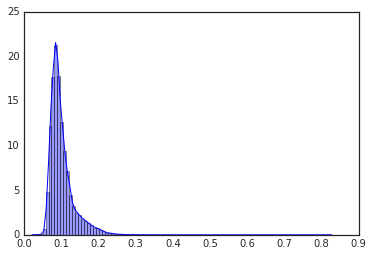

In [13]:
sns.set_style('white')
f = plt.figure()
plt.plot()
sns.distplot(values['green'], bins=100)

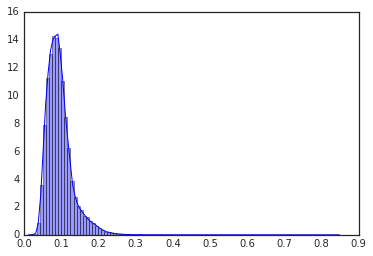

In [14]:
sns.set_style('white')
f = plt.figure()
plt.plot()
sns.distplot(values['red'], bins=100)

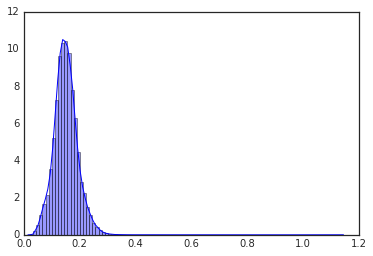

In [15]:
sns.set_style('white')
f = plt.figure()
plt.plot()
sns.distplot(values['nir'], bins=100)

### Посмотрим, сколько полигонов лежит в каждом срезе.

В атрибутах полигонов хранится закодированный номер среза, в котором было обнаружено изменение. Выглядит оно как "L78_x", где x - номер среза, например, L78_7. Для удобства дальнейшей работы определим функцию, которая возвращает номер среза по его названию.

In [16]:
def slice_num(name):
        return int(name.split('_')[1])

# Для примера
# name = 'L78_7'
# print slice_num(name)

Построим гистограмму распределения полигонов по срезам.

In [17]:
change = ee.Collection.loadTable('users/iglushko/FE2018/LE2017ch')
no_change = ee.Collection.loadTable('users/iglushko/FE2018/LE2017nochange')

slices = change.aggregate_array('NAME')

slice_vals = slices.getInfo()
slc_nums = [slice_num(s) for s in slice_vals]

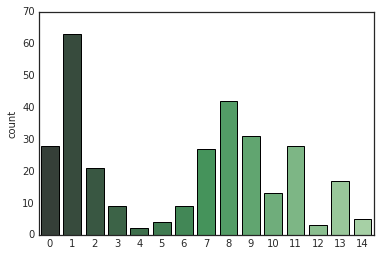

In [18]:
sns.countplot(x=slc_nums, palette="Greens_d", orient='v');

### Обучающее множество: пример на одном срезе

TODO:
 * Развалить обучающие полигоны на отдельные куски: каждый срез в своем отдельном растре.

### Выборка данных

Сгенерируем для обучения выборку на базе отрисованных полигонов рубок. Для примера возьмем один срез и построим на его базе обучающее множество, развалив полигоны на точки (пиксели). 
 
 * Выберем наугад номер среза TEST_SLICE_NUM, с которым будем работать (в дальнешейм распространим процедуру на остальные срезы).
 * Если изменение было обнаружено в каком-либо срезе, то предполагаем, что оно не было заметно на предыдущих снимках. Следовательно, построим обучающее множество из двух временных срезов - последнего снимка до TEST_SLICE_NUM (состояние до обнаружения) и снимка TEST_SLICE_NUM. Поэтому в обучающее множество точек с классом номер 1 (было изменение) пойдут точки из полигонов, маркированных срезом TEST_SLICE_NUM, в обучающее множество точек с классом номер 0 (изменения не было) положим точки со срезов, последующих за TEST_SLICE_NUM и точки из слоя no-change. С полигонами изменений, обнаруженых до TEST_SLICE_NUM ситуация сложнее: эти изменения могут быть заметны позднее, а может быть и нет. Поэтому на данном выкинем из из анализа, обработаем их позднее.

In [30]:
TEST_SLICE_NUM = 8  # Текущий анализируемый срез

def addSliceNum(feature):
    name = ee.String(feature.get('NAME'))
    test_slice = ee.Number(TEST_SLICE_NUM)
    slice_num = ee.Number.parse(name.slice(4))
    # IF Change return 1
    # IF not Change return 0
    # IF Change_unknown return -1
    num = ee.Algorithms.If(
        slice_num.lt(test_slice), 
        ee.Number(-1), 
        slice_num.eq(test_slice)
    )
    return ee.Feature(feature.geometry(), {'CLASS': num})

def addFalse(feature):
    return ee.Feature(feature.geometry(), {'CLASS': 0})

poly_samples = change.map(addSliceNum).merge(no_change.map(addFalse))
poly_samples = poly_samples.filter(ee.Filter.neq('CLASS', ee.Number(-1)))
# print(poly_samples.getInfo());


Поскольку снимок, непосредственно идущий перед TEST_SLICE_NUM может содержать пропуски в данных (облачность, к примеру), то для создания обучающего множества соберем снимок "ситуация до изменения" в виде композита, выбрав ближайший безоблачный снимок к TEST_SLICE_NUM.

In [31]:
current_slice = ee.Image(data.toList(1, offset=TEST_SLICE_NUM-1).get(0))
before_slice = ee.Image(data.toList(1, offset=TEST_SLICE_NUM-2).get(0))
# Переименуем 
names = before_slice.bandNames().getInfo()
names = [n + '_before' for n in names]
# print names
before_slice = before_slice.rename(names)

train_image = ee.Image.cat(current_slice, before_slice)
# print train_image.getInfo()

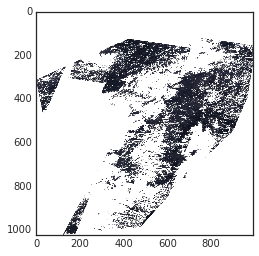

In [32]:
im = train_image.visualize(**vis)

path = 'aggr.png'
download(im, aoi, path)
show(path)

In [33]:
sample = train_image.sampleRegions(collection=poly_samples, properties = ['CLASS'], scale=30)

In [34]:
# counts = sample.aggregate_histogram('CLASS').getInfo()
# print counts

In [35]:
bands = ['blue', 'green', 'red', 'nir', 'ndsi', 'nir_before', 'red_before', 'green_before', 'blue_before', 'ndsi_before']
trained = ee.Classifier.randomForest(1000, 0, 100, 0.5, False, 42).train(sample, 'CLASS', bands);
classified = train_image.select(bands).classify(trained);

# print classified.getInfo()

In [36]:
# path = 'result.png'
# download(classified, aoi, path)
# show(path)

In [37]:
task = ee.batch.Export.image.toAsset(image=classified, assetId='users/kolesovdm/test_classified_before_1000', scale=150)
print('Start task')
task.start()

Start task
